# How to PLD with TESS
------------------------------------
An iPython tutorial --- by **Néstor Espinoza (nespinoza@stsci.edu)**

In this iPython notebook, we will perform all the steps from lightcurve extraction to actual light curve fitting with Pixel Level Decorrelation (PLD) --- a technique which was successful both in Spitzer and Kepler, applied to TESS. 

In this example, we will play with the data of TOI-141b --- a star which has a short-period super-Earth transiting exoplanet orbiting around it. Let's begin!

## 1. Introduction 

First things first: let's import some libraries!

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np

import seaborn as sns
from astropy.io import fits

/Users/nespinoza/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Light curve extraction

We begin this notebook by extracting both the photometry and the light curve of each pixel from a set of Target Pixel Files obtained from MAST Archive for this target. First, we generate a median image using all the target pixel files obtained for it:

In [2]:
fname = 'tess2018206045859-s0001-0000000403224672-0120-s_tp.fits'
tess_id = fname.split('-s_tp')[0]
d = fits.getdata(fname)
ntimes = len(d)

if os.path.exists(tess_id+'_mi.npy'):
    median_image = np.load(tess_id+'_mi.npy')
else:
    # First go through all the TPF of the time-series to generate the median image, which will generate our TPF mask:
    firstime = True
    for i in range(ntimes):
        if firstime:
            ss = d[i][4]
            firstime = False
        else:
            ss = np.dstack((ss,d[i][3]))
    median_image = np.median(ss,axis=2)
    np.save(tess_id+'_mi.npy',median_image)

Let's plot it to see how it looks like:

Text(0, 0.5, 'Pixel')

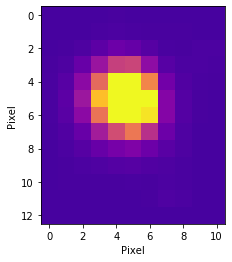

In [3]:
im = plt.imshow(median_image, cmap = plt.get_cmap('plasma'))
im.set_clim(200000,300000)
plt.xlabel('Pixel')
plt.ylabel('Pixel')

As expected, it seems the signal is mainly located in some brightest central pixels. Now, let's define the number of pixels $N$ that we want to use to extract the light curve, identify _where_ those pixels are, and fill an array with ones where those pixels are, and zeros otherwise. We will use this "mask" later to identify both the "science" pixels, with the light from our target, and the "background" pixels. Here, we will select the $N$ brightest pixels to create this mask:

In [4]:
npixels = 10
if os.path.exists(tess_id+'_mask'+str(npixels)+'.npy'):
    mask = np.load(tess_id+'_mask'+str(npixels)+'.npy')
    mask_idxs = np.load(tess_id+'_mask_idxs_'+str(npixels)+'.npy')
    mask_idys = np.load(tess_id+'_mask_idys_'+str(npixels)+'.npy')
else:
    # Generate the TPF mask; an array of zeros and ones. Ones are values that will be added to the aperture photometry. For this, 
    # first identify the values of the npixels brightest pixels in the median image:
    cpixels = -1
    flat_mi = median_image.flatten()
    values = np.array([])
    while cpixels < npixels:
        max_val = np.max(flat_mi)
        idx = np.where(flat_mi == max_val)[0]
        values = np.append(values, flat_mi[idx])
        flat_mi = np.delete(flat_mi,idx)
        cpixels += len(idx)
    # With these values, now fill the mask:
    mask = np.zeros(median_image.shape)
    mask_idxs = np.array([])
    mask_idys = np.array([])
    for i in range(len(values)):
        idx = np.where(median_image == values[i])
        mask_idxs = np.append(mask_idxs,idx[0][0])
        mask_idys = np.append(mask_idys,idx[1][0])
        mask[idx] = 1.
    np.save(tess_id+'_mask_idxs_'+str(npixels)+'.npy',mask_idxs)
    np.save(tess_id+'_mask_idys_'+str(npixels)+'.npy',mask_idys)
    np.save(tess_id+'_mask_'+str(npixels)+'.npy',mask)

Let's plot this mask on top of the image above:

Text(0, 0.5, 'Pixel')

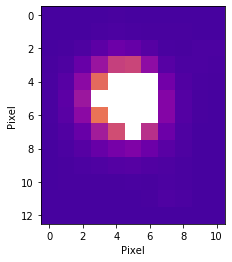

In [5]:
im = plt.imshow(median_image, cmap = plt.get_cmap('plasma'))
im.set_clim(200000,300000)
im2 = plt.imshow(np.ma.masked_where(mask == 0, mask),alpha=1.0,cmap='Greys')
plt.xlabel('Pixel')
plt.ylabel('Pixel')

This seems great! Now, let's extract the fluxes (and errors). To this end, let's use all the pixels outside this mask as proxys for the background of each TPF --- take their median, and substract that to the image. To get the flux (and errors) then, simply sum (in quadrature for therrors) the background-substracted pixels inside the mask --- and that's it!

In [6]:
# Identify pixels which are in the background:
bkg_flat_idx= np.where(mask.flatten() == 0.)
# Prepare arrays that will save the output values:
times, fluxes, fluxes_errors, flux_pixels = np.array([]), np.array([]), np.array([]), np.array([])
fout = open(tess_id+'_lc.dat','w')
fout2 = open(tess_id+'_tpf_lc.dat','w')
for i in range(ntimes):
    ct, ctpf, ctpf_err = d[i][0]+2457000., d[i][4], d[i][5]
    if ~np.isnan(ct):
        ctpf = ctpf - np.median(ctpf.flatten()[bkg_flat_idx])
        c_flux = np.sum(ctpf*mask)
        c_flux_err = np.sqrt(np.sum((ctpf_err*mask)**2)/(npixels))
        if ~np.isnan(c_flux) and ~np.isnan(c_flux_err):
            fout.write('{0:.10f} {1:.10f} {2:.10f}\n'.format(ct,c_flux,c_flux_err))
            s = '{0:.10f}'.format(ct)
            for j in range(len(mask_idxs)):
                s = s + ' {0:.10f}'.format(ctpf[int(mask_idxs[j]),int(mask_idys[j])])
            fout2.write(s+'\n')
fout.close()
fout2.close()

Let's check how the light curve looks like:

Text(0, 0.5, 'Relative flux')

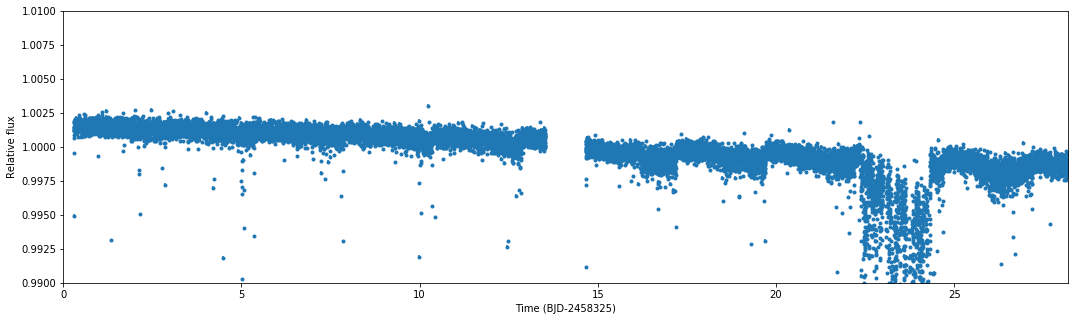

In [7]:
t,f,ferr = np.loadtxt(tess_id+'_lc.dat',unpack=True)
plt.figure(figsize=(18,5))
tstart = int(t[0])
plt.errorbar(t-tstart,f/np.median(f),ferr/np.median(f),fmt='.')
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')

So far, so good! There are some issues, of course. The systematics are evident; there are lots of outliers --- and the transit is not immediately evident. We will have to take care of all that when doing PLD. With those caveats in mind let's continue to performing PLD!

## 3. Doing PLD

Let's first get both, the times, fluxes and errors for the target lightcurve, and the lightcurve of each of the pixels that we extracted in the previous section:

In [8]:
# Get times, fluxes, errors:
t,f,ferr = np.loadtxt(tess_id+'_lc.dat',unpack=True)
# Get pixel fluxes:
all_pixels = np.genfromtxt(tess_id+'_tpf_lc.dat',dtype=None)
# Substract one to the second dimension because the first column are the times:
ntimes, npixels = len(all_pixels),len(all_pixels[0])-1
pixel_fluxes = np.zeros([ntimes, npixels])
for i in range(ntimes):
    pixel_fluxes[i,:] = all_pixels[i][1:]    

Before continuing, let's get rid of outliers:

In [12]:
from scipy.signal import medfilt
norm_lc = f/np.median(f)
mf = medfilt(norm_lc,41)
residuals = norm_lc/mf - 1.
idx = np.where(np.abs(residuals)<0.001)[0]
t, f, ferr = t[idx][2:], f[idx][2:], ferr[idx][2:]
pixel_fluxes = pixel_fluxes[idx, :]
pixel_fluxes = pixel_fluxes[2:,:]

Let's plot to see how we did:

Text(0, 0.5, 'Relative flux')

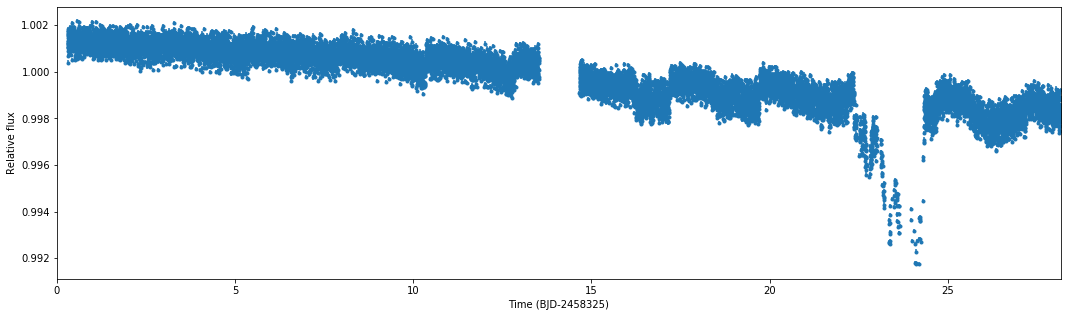

In [13]:
tstart = int(t[0])
plt.figure(figsize=(18,5))
plt.errorbar(t-tstart,f/np.median(f),ferr/np.median(f),fmt='.')
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')

That's much better. We might have removed some important datapoints, but for the purposes of this excercise, that's OK.

We checked the flux of the target star in the previous section. What about the _pixel_ fluxes? To check them out, let's plot their standarized version, along with the standarized version of the lightcurve. With "standarize" we mean substracting their mean/median, and dividing them by their standard deviation. This will allow all those signals to have the same amplitude, and vary along the same axis (0):

/Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


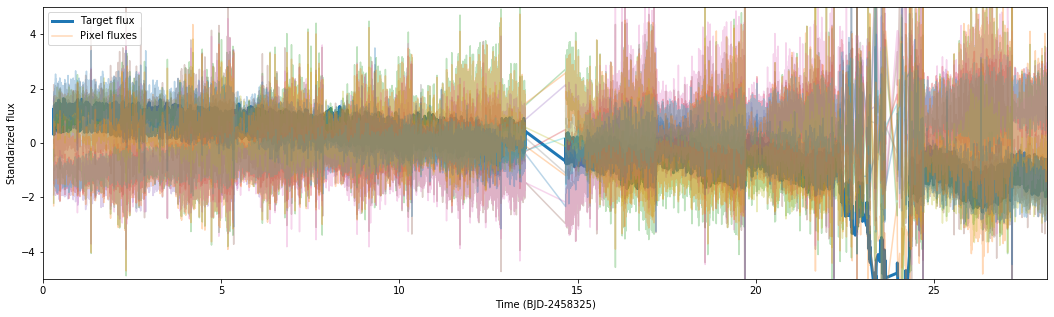

In [14]:
def get_mad_sigma(x):
    """
    Estimate the robust version of the standard deviation (sigma) using the Median Absolute Deviation (MAD).
    See: https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return np.median(np.abs(x-np.median(x)))*1.4826

def standarize(x):
    return (x-np.median(x))/get_mad_sigma(x)

plt.figure(figsize=(18,5))
tstart = int(t[0])
plt.plot(t-tstart,standarize(f),'-',lw=3,label='Target flux')
for j in range(npixels):
    if j == 0:
        plot_name = 'Pixel fluxes'
    else:
        plot_name = None
    plt.plot(t-tstart, standarize(pixel_fluxes[:,j]),'-',alpha=0.3, label = plot_name)
plt.ylim(-5,5)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Standarized flux')
plt.legend()

As expected, the fluxes follow, more or less, the variations in the target flux. There are pixels that follow it better than others (there are others that seem to be wanting to follow a linear trend), but overall, it seems they do OK. 

### 3.1 First-order PLD

Let's start by applying first-order PLD to the data. On first order PLD, the regressors are simply $\hat{P}_i(t) = P_i(t)/\sum_i P_i(t)$. In addition, we add a regressor that accounts for the out-of-transit flux --- so our model for the target flux would be of the form: $F(t) = A + \sum a_i \hat{P}_i(t)$. Being this a linear model, this should be relatively straightforward to fit. 

Let's form the $\hat{P}_i(t)$:

In [78]:
Phat = np.zeros(pixel_fluxes.shape)
Psum = np.sum(pixel_fluxes,axis=1)
for i in range(Phat.shape[0]):
    Phat[i,:] = pixel_fluxes[i,:]/Psum[i]

With these regressors at hand, let's fit the data. Before we do it, however, we note that we want to use only the out-of-transit data to obtain the coefficients $A$ and $a_i$. We use the transit ephemerides $P=1.008035$, $t_0 = 2458379.97043$ and assume a transit duration of about 3 hours so $T_{14} = 3/24$ days. With this, we mask the out-of-transit datapoints, and perform PLD:

In [79]:
def get_phases(t,P,t0):
    """ 
    Given input times, a period (or posterior dist of periods)
    and time of transit center (or posterior), returns the 
    phase at each time t.
    """
    if type(t) is not float:
        phase = ((t - np.median(t0))/np.median(P)) % 1
        ii = np.where(phase>=0.5)[0]
        phase[ii] = phase[ii]-1.0
    else:   
        phase = ((t - np.median(t0))/np.median(P)) % 1
        if phase>=0.5:
            phase = phase - 1.0
    return phase

# Obtain phases/times that are out-of-transit:
P, t0, T14 = 1.008035, 2458379.97043, 3./24.
phases = get_phases(t, P, t0)
idx_oot = np.where(np.abs(phases) > (T14/P)*0.5)[0]

# Regress PLD on those out-of-transit datapoints. Add a matrix of ones to account for the A coefficient:
X = np.vstack(( np.ones(Phat.shape[0]), Phat.T ))
# Perform linear regression to obtain coefficients on out-of-transit data:
result = np.linalg.lstsq(X.T[idx_oot,:], f[idx_oot])
coeffs = result[0]

/Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


All right! Let's see how we did. To this, use the coefficients to predict the entire TESS time-series, using both in and out-of-transit datapoints:

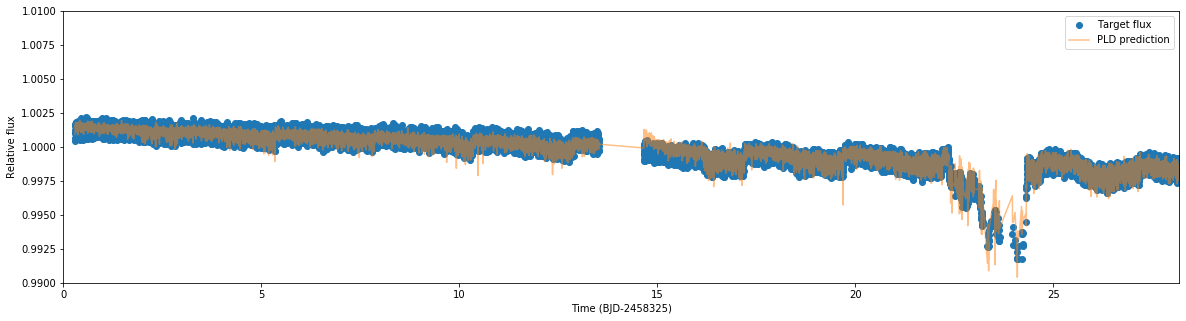

In [80]:
# Create prediction:
prediction = np.dot(coeffs, X)
plt.figure(figsize=(20,5))
# Plot alongside data:
plt.plot(t-tstart,f/np.median(f),'o',label='Target flux')
plt.plot(t-tstart,prediction/np.median(f),label='PLD prediction',alpha=0.5)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')
plt.legend()

All right, that looks pretty decent! Let's apply them to the whole dataset to see how we do:

Text(0, 0.5, 'Relative flux')

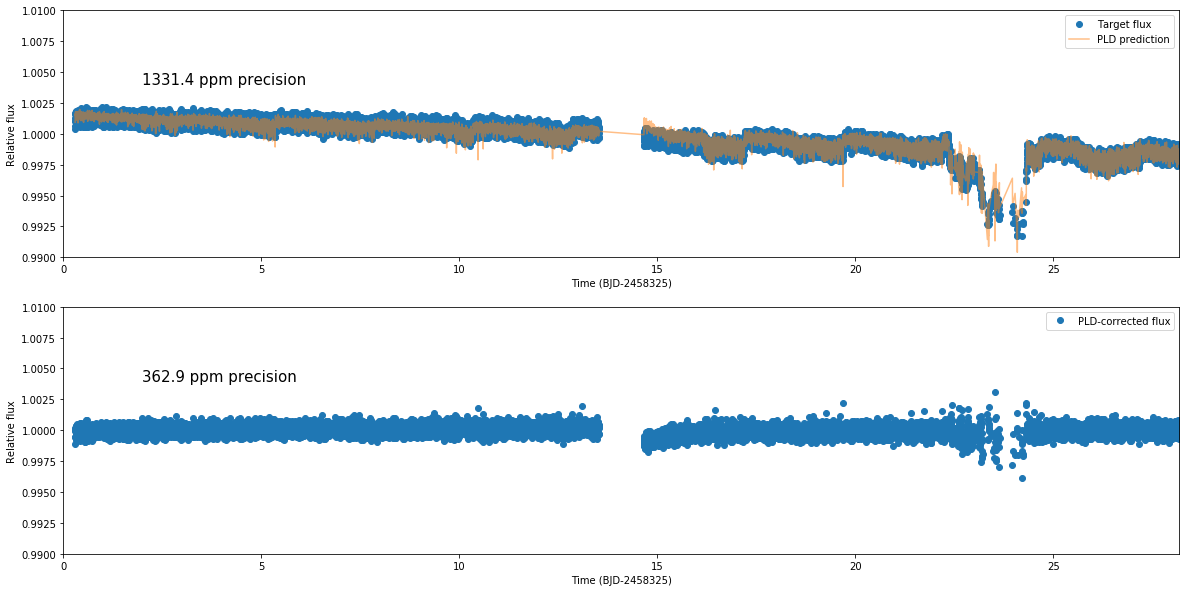

In [81]:
# Create prediction:
prediction = np.dot(coeffs, X)
plt.figure(figsize=(20,10))
# Plot alongside data:
plt.subplot(211)
plt.plot(t-tstart,f/np.median(f),'o',label='Target flux')
plt.plot(t-tstart,prediction/np.median(f),label='PLD prediction',alpha=0.5)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(f/np.median(f))*1e6),fontsize=15)
plt.legend()

plt.subplot(212)
corrected_flux = f/prediction
plt.plot(t-tstart,corrected_flux/np.median(corrected_flux),'o',label='PLD-corrected flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(corrected_flux/np.median(corrected_flux))*1e6),fontsize=15)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.legend()
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')

Hey, that's _a lot_ of improvement! Almost 1000 ppm better than the raw lightcurves. Can we do better?

### 3.2 First order PLD, selected $\hat{P}_i(t)$ only

One of the main criticisms that can one might do to the fit done above is that we are regressing 42 terms to our dataset. So --- could we be overfitting? Could it be that some $\hat{P}_i(t)$ are just redundant, i.e., they just give the same information? To check if this might be the case, a good first-order measure is to compute the correlation matrix of the coefficients. Such a matrix presents in the $(i,j)$ element the correlation coefficient between term $i$ and term $j$. A totally independant correlation matrix would be diagonal --- no correlation between the terms, they would only be (perfectly) correlated with themselves. 

Let's have a look: 

Text(0, 0.5, 'Element $j$')

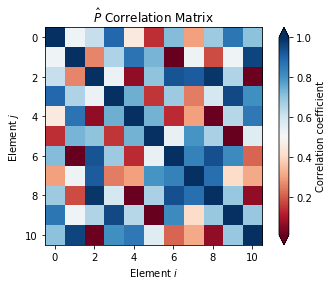

In [82]:
CorrelationMatrix = np.abs(np.corrcoef(Phat.T))
plt.title('$\hat{P}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix,cmap='RdBu')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Oh boy! Very far away from a perfectly diagonal matrix. This means there is tons of redundant information that we have to be careful about. Luckily, there is a way out: Principal Component Analysis (PCA).

PCA is a method with which we can transform a set of highly correlated components, into a space in which they are completely uncorrelated. One of the most useful things of PCA is that we can not only perform this mapping, but also the method returns to us a measure of how important each of the transformed components is to explain the data --- the eigenvalues of each component. In this way, we can "cut" the number of components we use, effectively reducing the dimenionality of the problem. So, currently, we fit 42 components --- it might be that with PCA, we only need, say, 10. Neat, huh?

Here's the beautiful part of PCA: it is "only" a singular-value decomposition (SVD) of the dataset. That's it. That's it magic. Let's perform this transformation on our regressors:

In [83]:
def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = get_mad_sigma(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

V, eigenvalues, PCA = classic_PCA(Phat.T)

Let's start by plotting the correlation matrix of the PCAs:

Text(0, 0.5, 'Element $j$')

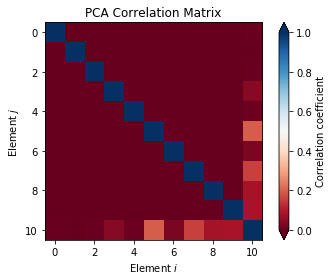

In [84]:
PCACorrelationMatrix = np.abs(np.corrcoef(PCA))
plt.title('PCA Correlation Matrix')
im = plt.imshow(PCACorrelationMatrix,cmap='RdBu')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Nice! Note how the PCA correlation matrix is almost diagonal --- except for the very last term. This is usually just noise, and is ought to have some larger correlation than the other components. What do the eigenvalues say?:

Text(0, 0.5, 'Eigenvalue')

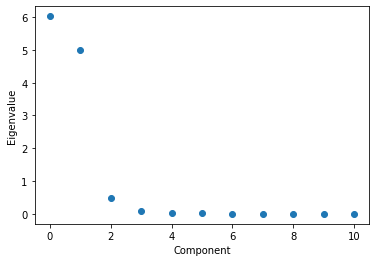

In [85]:
plt.plot(eigenvalues,'o')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')

All right, this is nice --- the eigenvalues decrease as we go to higher components. It seems that the curve more or less flattens at about 5 components. Let's see how we do with those numbers of components:

In [89]:
X = np.vstack(( np.ones(len(f)), PCA[:5,:] ))
#X = np.vstack(( np.ones(len(f)), PCA[:,:] ))
# Fit:
result = np.linalg.lstsq(X.T[idx_oot,:], f[idx_oot])
coeffs = result[0]

/Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


All right! Let's see how we do with these new regressors/coefficients:

(6, 17518)


Text(0, 0.5, 'Relative flux')

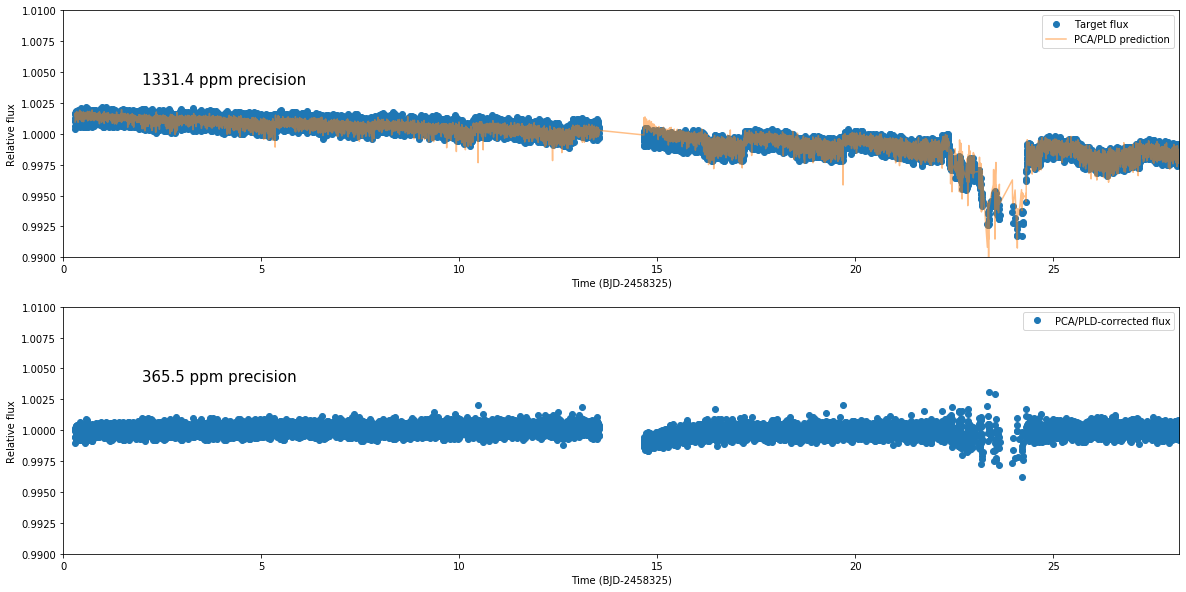

In [90]:
# Create prediction:
print(X.shape)
prediction = np.dot(coeffs, X)
plt.figure(figsize=(20,10))
# Plot alongside data:
plt.subplot(211)
plt.plot(t-tstart,f/np.median(f),'o',label='Target flux')
plt.plot(t-tstart,prediction/np.median(f),label='PCA/PLD prediction',alpha=0.5)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(f/np.median(f))*1e6),fontsize=15)
plt.legend()

plt.subplot(212)
corrected_flux = f/prediction
plt.plot(t-tstart,corrected_flux/np.median(corrected_flux),'o',label='PCA/PLD-corrected flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(corrected_flux/np.median(corrected_flux))*1e6),fontsize=15)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.legend()
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')

Hey, that's great! Using all components we get down to 363 ppm (i.e., plot above) --- using only 5 we get down to 365 ppm. Can we improve all this further? Let's see if we can do better with second-order PLD!

### 3.3 Second-order PLD

Let's try second-order PLD, and see if this improves things. Here, the idea is that the full model is of the form: $F(t) = A + \sum_i a_i \hat{P}_i(t) + \sum_i \sum_j b_{i,j} \hat{P}_i(t) \hat{P}_j(t) = A + \sum_i a_i \hat{P}_i(t) + \sum_i \sum_j b_{i,j} \hat{Q}_{i,j}(t)$. 

Let's first compute the $\hat{Q}_{i,j}(t)$:

In [91]:
import itertools
all_pairs = list(itertools.combinations(range(Phat.shape[1]), 2))
Qhat = np.zeros([Phat.shape[0],len(all_pairs)])
for i in range(len(all_pairs)):
    Qhat[:,i] = Phat[:,all_pairs[i][0]]*Phat[:,all_pairs[i][1]]

And now let's append that to the $\hat{P}$ matrix to form the second-order PLD regressors:

In [92]:
SO_regressors = np.vstack((Phat.T, Qhat.T)).T

Now **this** is a big matrix of regressors --- over 800! Let's check the correlation matrix of this:

Text(0, 0.5, 'Element $j$')

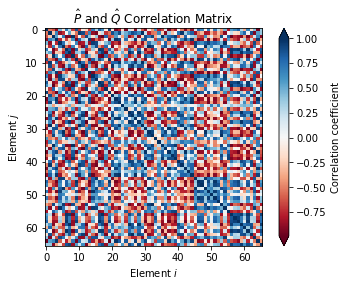

In [93]:
CorrelationMatrix = np.corrcoef(SO_regressors.T)
plt.title('$\hat{P}$ and $\hat{Q}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix,cmap='RdBu')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Woops. Tons of redundant information. Let's apply PCA, and check the eigenvalues to see if we can perform some dimensionality reduction:

In [94]:
V, eigenvalues, PCA = classic_PCA(SO_regressors.T)

Text(0, 0.5, 'Eigenvalue')

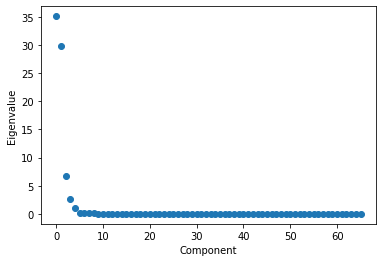

In [95]:
plt.plot(eigenvalues,'o')
#plt.yscale('log')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')

It is not entirely clear where to cut this plot. It seems about 10 components it starts to flatten out. Let's try those:

/Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


Text(0, 0.5, 'Relative flux')

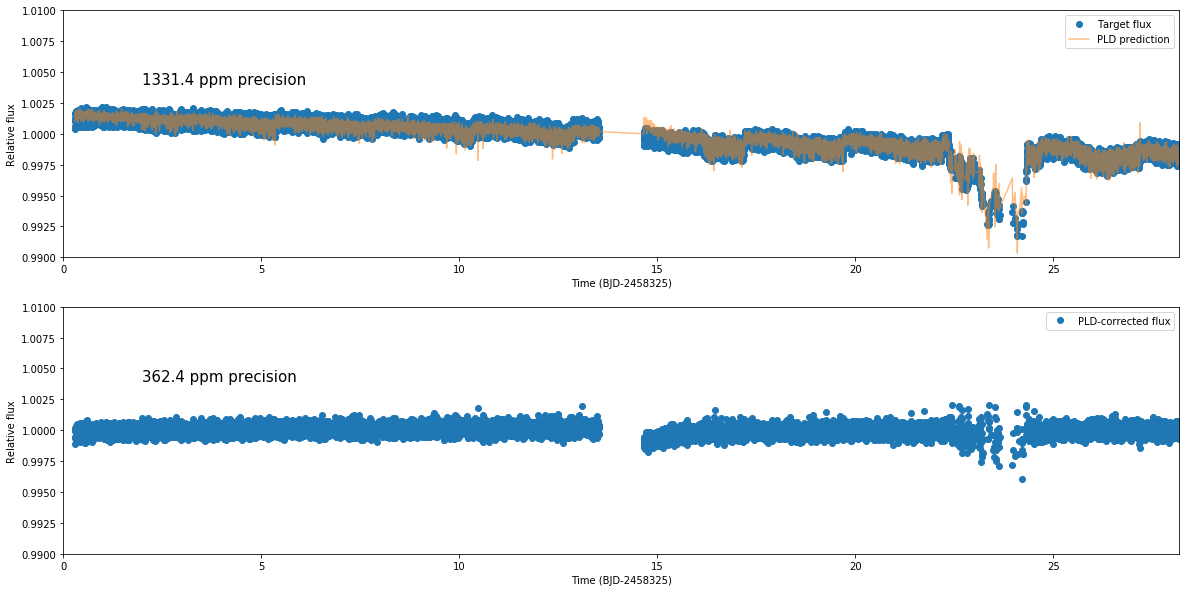

In [96]:
# New regressors are the PCA up to tenth component:
X = np.vstack(( np.ones(PCA.shape[1]), PCA[:10,:] ))

# Fit:
result = np.linalg.lstsq(X.T[idx_oot,:], f[idx_oot])
coeffs = result[0]

# Predict:
prediction = np.dot(coeffs, X)

plt.figure(figsize=(20,10))
# Plot alongside data:
plt.subplot(211)
plt.plot(t-tstart,f/np.median(f),'o',label='Target flux')
plt.plot(t-tstart,prediction/np.median(f),label='PLD prediction',alpha=0.5)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(f/np.median(f))*1e6),fontsize=15)
plt.legend()

plt.subplot(212)
corrected_flux = f/prediction
plt.plot(t-tstart,corrected_flux/np.median(corrected_flux),'o',label='PLD-corrected flux')
plt.text(2,1.0040,'{0:.1f} ppm precision'.format(get_mad_sigma(corrected_flux/np.median(corrected_flux))*1e6),fontsize=15)
plt.ylim(0.99,1.01)
plt.xlim(0,np.max(t-tstart))
plt.legend()
plt.xlabel('Time (BJD-{})'.format(tstart))
plt.ylabel('Relative flux')

It seems second-order PLD does not add much improvement. The main reason seems to be some smooth components in the data (e.g., the small rise around ~15 in the plot above) --- how do we characterize those? Next-up --- Gaussian Process!

## 4. PLD + Gaussian Processes

One cleaver way to account for smooth components in the data is to use a Gaussian Process. To do this, we will use `juliet` to fit for a GP _and_ PLD. First, we obtain the 10 PCA-regressors of the first-order PLD: